In [36]:
import os
import sys
import math
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from math import exp, sqrt, log
import time
import geopandas as gpd
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
if '..' not in sys.path:
    sys.path.append('..')
from importlib import reload
#reload(util_tools)
import util_tools
from util_tools.data_loader import data_processer
import random

# 1. Data Processing

In [7]:
# define necessary parameters
target_var = 'DUEXTTAU'
file_path_g_06 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
file_path_ele = r'C:\Users\96349\Documents\Downscale_data\elevation\elevation_data.npy'
file_path_country = [r'C:\Users\96349\Documents\Downscale_data\Country_shape\ARE_adm/ARE_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\IRQ_adm/IRQ_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\KWT_adm/KWT_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\QAT_adm/QAT_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\SAU_adm/SAU_adm0.shp']
n_lag = 20
n_pred = 1
task_dim = [5, 5]

In [12]:
g_data = nc.Dataset(file_path_g_05)
g_data = g_data.variables[target_var][:]

Text(0, 0.5, 'Frequency')

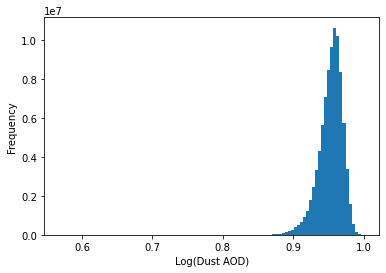

In [21]:
plt.hist(g_data.reshape(np.prod(g_data.shape)), bins=100)
plt.xlabel('Log(Dust AOD)')
plt.ylabel('Frequency')

In [3]:
def plot_image(single_image_data, title, lats, lons, save_plt=False):
    '''
    if is_merra:
        lons = MERRA_data.variables['lon'][:]
        lats = MERRA_data.variables['lat'][:]
    else:
        lons = G5NR_data.variables['lon'][:]
        lats = G5NR_data.variables['lat'][:]
    '''
    m = Basemap(projection='merc',llcrnrlon=25.,llcrnrlat=10.,urcrnrlon=75.,urcrnrlat=45. , resolution='h', epsg = 4326)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    parallels = np.arange(10,43,5.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(25,75,5.) # make longitude lines every 5 degrees from 95W to 70W
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
    m.shadedrelief(scale=0.5)
    m.pcolormesh(lons, lats, single_image_data, latlon=True)
    plt.clim(0, single_image_data.max())
    m.drawcoastlines(color='lightgray')
    plt.title(title)
    plt.colorbar()
    if save_plt:
        plt.savefig(title+'.jpg')

In [3]:
#reload(util_tools.data_loader)
import util_tools.data_loader as data_loader
data_processor = data_loader.data_processer()

In [4]:

g_data, m_data, [G_lats, G_lons, M_lats, M_lons], ele_data = data_processor.load_data(target_var, file_path_g_05, file_path_g_06, 
                                                                                      file_path_m, file_path_ele, file_path_country, normalize=False)

In [5]:
m_data = data_processor.unify_m_data(g_data[:10], m_data, G_lats, G_lons, M_lats, M_lons)

In [6]:
match_m_data = m_data[range(1826, 1826+730), :, :]

In [8]:
match_m_data.shape

(730, 342, 352)

In [33]:
croped_g, croped_m, croped_ele, lats, lons = data_processor.cut_country(g_data, match_m_data, [G_lats, G_lons, M_lats, M_lons], ele_data)

In [66]:
croped_ele.shape

(340, 349)

In [11]:
X_high, X_low, X_ele, X_other, Y = data_processor.flatten(g_data[:n_lag+1, :5, :5], match_m_data[:n_lag+1, :5, :5], ele_data[:5, :5],
                                                          [G_lats[:5], G_lons[:5]], list(range(n_lag+1)), n_lag=n_lag, n_pred=n_pred, task_dim=task_dim, is_perm=True, 
                                                          return_Y=True, return_nan=False)

In [58]:
Y.shape

(1, 1, 5, 5)

In [56]:
cont = np.zeros((1, 1, task_dim[0], task_dim[1]))
cont.shape

(1, 5, 5, 1)

In [59]:
np.concatenate([Y, Y], axis=0).shape

(2, 1, 5, 5)

In [31]:
days = list(range(1, 731))
season = 1
year1 = list(range((season-1)*91+n_lag, season*91 if season !=4 else season*91+1))
year2 = list(range(365+(season-1)*91+n_lag, 365+season*91 if season !=4 else 365+season*91+1))

In [39]:
avlb_days = set(year2 +year1)
test_set = set(random.sample(avlb_days, int(len(avlb_days)*0.1)))
train_set = avlb_days - test_set

In [48]:
for day in train_set:
        # get flattened data of target day
    X_high1, X_low1, X_ele1, X_other1, Y1 = data_processor.flatten(g_data[day-n_lag:day+1], 
                                                                       match_m_data[day-n_lag:day+1], 
                                                                       ele_data,
                                                                       [G_lats, G_lons], 
                                                                       days[day-n_lag:day+1], 
                                                                       n_lag=n_lag,
                                                                       n_pred=n_pred, 
                                                                       task_dim=task_dim,
                                                                       is_perm=True, 
                                                                       return_Y=True, 
                                                                       stride=2)

KeyboardInterrupt: 

# 2. GAN model test

In [158]:
def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def mapping_to_target_range( x, target_min=0, target_max=1 ): 
    x02 = tf.keras.backend.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min


high_input = tf.keras.Input(shape=(n_lag, task_dim[0], task_dim[1], 1))
x1 = tf.keras.layers.ConvLSTM2D(32, kernel_size=(3,3), return_sequences=True, activation=tf.keras.layers.LeakyReLU())(high_input)
x1 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(3,3), return_sequences=True, activation=tf.keras.layers.LeakyReLU())(x1)
x1 = tf.keras.layers.Reshape([n_lag, 16])(x1)
x1 = tf.keras.layers.LSTM(32, activation=tf.keras.layers.LeakyReLU())(x1)
x1 = tf.keras.layers.Flatten()(x1)

low_input = tf.keras.Input(shape=(n_lag, task_dim[0], task_dim[1], 1))
x2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(3,3), return_sequences=False, activation=tf.keras.layers.LeakyReLU())(low_input)
x2 = tf.keras.layers.Flatten()(x2)

ele_input = tf.keras.Input(shape=(task_dim[0], task_dim[1], 1))
x3 = tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU())(ele_input)
x3 = tf.keras.layers.Flatten()(x3)

other_input =  tf.keras.Input(shape=(3))
x4 = tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU())(other_input)

x = tf.keras.layers.Concatenate(axis=1)([x1, x2, x3, x4])
#x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(30, kernel_initializer="he_normal", use_bias=True, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(n_pred*np.prod(task_dim), activation=nnelu)(x)
x = tf.keras.layers.Reshape([n_pred, task_dim[0], task_dim[1]])(x)
generator = tf.keras.Model([high_input, low_input, ele_input, other_input], x)
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
generator.compile(optimizer=opt, loss='mean_absolute_error')

In [152]:
generator.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_187 (InputLayer)         [(None, 20, 5, 5, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_47 (ConvLSTM2D)    (None, 20, 3, 3, 32  38144       ['input_187[0][0]']              
                                )                                                                 
                                                                                                  
 conv_lstm2d_48 (ConvLSTM2D)    (None, 20, 1, 1, 16  27712       ['conv_lstm2d_47[0][0]']         
                                )                                                          

In [41]:
# define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
best_save = tf.keras.callbacks.ModelCheckpoint('s2s_model', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [lr_scheduler, early_stopping, best_save]

history = generator.fit([X_high[:-3], X_low[:-3], X_ele[:-3], X_other[:-3]], Y[:-3], epochs=20, callbacks=callbacks, validation_split=0.25)

Epoch 1/20
444/444 [==============================] - ETA: 0s - loss: 0.0036

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 104s 199ms/step - loss: 0.0036 - val_loss: 0.0028 - lr: 0.0050
Epoch 2/20
444/444 [==============================] - ETA: 0s - loss: 0.0025

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 90s 203ms/step - loss: 0.0025 - val_loss: 0.0026 - lr: 0.0050
Epoch 3/20
444/444 [==============================] - ETA: 0s - loss: 0.0023

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 99s 223ms/step - loss: 0.0023 - val_loss: 0.0021 - lr: 0.0050
Epoch 4/20
444/444 [==============================] - ETA: 0s - loss: 0.0018

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 100s 225ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 0.0050
Epoch 5/20
444/444 [==============================] - ETA: 0s - loss: 0.0016

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 99s 222ms/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0050
Epoch 6/20
444/444 [==============================] - ETA: 0s - loss: 0.0014

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 104s 235ms/step - loss: 0.0014 - val_loss: 0.0012 - lr: 0.0050
Epoch 7/20
444/444 [==============================] - 83s 187ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0050
Epoch 8/20
444/444 [==============================] - ETA: 0s - loss: 7.6257e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 268s 606ms/step - loss: 7.6257e-04 - val_loss: 7.2444e-04 - lr: 5.0000e-04
Epoch 9/20
444/444 [==============================] - ETA: 0s - loss: 7.1858e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 246s 554ms/step - loss: 7.1858e-04 - val_loss: 7.0061e-04 - lr: 5.0000e-04
Epoch 10/20
444/444 [==============================] - ETA: 0s - loss: 6.6665e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 249s 561ms/step - loss: 6.6665e-04 - val_loss: 6.7604e-04 - lr: 5.0000e-05
Epoch 11/20
444/444 [==============================] - ETA: 0s - loss: 6.6071e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 258s 583ms/step - loss: 6.6071e-04 - val_loss: 6.7153e-04 - lr: 5.0000e-06
Epoch 12/20
444/444 [==============================] - ETA: 0s - loss: 6.5988e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 101s 226ms/step - loss: 6.5988e-04 - val_loss: 6.7107e-04 - lr: 5.0000e-07
Epoch 13/20
444/444 [==============================] - ETA: 0s - loss: 6.5973e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 84s 188ms/step - loss: 6.5973e-04 - val_loss: 6.7107e-04 - lr: 5.0000e-08
Epoch 14/20
444/444 [==============================] - ETA: 0s - loss: 6.5971e-04

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


444/444 [==============================] - 93s 210ms/step - loss: 6.5971e-04 - val_loss: 6.7107e-04 - lr: 5.0000e-09
Epoch 15/20
444/444 [==============================] - 74s 167ms/step - loss: 6.5971e-04 - val_loss: 6.7107e-04 - lr: 5.0000e-10
Epoch 16/20
444/444 [==============================] - 80s 179ms/step - loss: 6.5971e-04 - val_loss: 6.7107e-04 - lr: 5.0000e-11


In [13]:
np.round(history.history['val_loss'][0], 5)

0.00288

In [30]:
generator.predict([X_high[-2:], X_low[-2:], X_ele[-2:], X_other[-2:]])

array([[[[0.9683484 , 0.96832466, 0.9684444 , 0.9683692 , 0.9683214 ],
         [0.968474  , 0.9686263 , 0.968424  , 0.9686136 , 0.96835846],
         [0.96901035, 0.9686748 , 0.9686676 , 0.96846926, 0.9686164 ],
         [0.9689779 , 0.9690416 , 0.9688366 , 0.96887684, 0.96885645],
         [0.96941286, 0.96907026, 0.96910024, 0.9691295 , 0.9690287 ]]],


       [[[0.96257615, 0.96265596, 0.9623643 , 0.96205795, 0.962199  ],
         [0.96267664, 0.96240705, 0.9626488 , 0.962477  , 0.9623253 ],
         [0.96281916, 0.9626843 , 0.9629285 , 0.9627611 , 0.96267354],
         [0.96320665, 0.9629062 , 0.96322626, 0.96293634, 0.9628102 ],
         [0.96353036, 0.96328497, 0.96316195, 0.9628848 , 0.9629948 ]]]],
      dtype=float32)

In [16]:
Y[-2:]

array([[[[0.96209797, 0.9621877 , 0.96193371, 0.96189912, 0.96229232],
         [0.96203399, 0.96214366, 0.96209948, 0.9618981 , 0.96197329],
         [0.96180667, 0.96200721, 0.96211405, 0.96204762, 0.96190014],
         [0.96150141, 0.96180359, 0.96189352, 0.96187211, 0.9616579 ],
         [0.96111839, 0.96135704, 0.96149043, 0.96148572, 0.96143228]]],


       [[[0.96630322, 0.96626718, 0.96622566, 0.96619059, 0.96614191],
         [0.96634224, 0.96628981, 0.96623644, 0.96618365, 0.96611053],
         [0.96633115, 0.96626986, 0.96620216, 0.96613494, 0.96606159],
         [0.96629403, 0.96621372, 0.96615042, 0.96611402, 0.96609423],
         [0.96622451, 0.96617284, 0.96615003, 0.96614539, 0.96615042]]]])

In [20]:
g2_model = tf.keras.models.load_model('s2s_model')

In [27]:
pd.DataFrame(history.history).to_csv('history.csv')

In [26]:
pred_Y = g2_model.predict([X_high[-1:], X_low[-1:], X_ele[-1:], X_other[-1:]])

In [28]:
pred_Y.mean()

0.9427106

In [112]:
np.sqrt(np.mean(np.square(pred_Y[-1] - Y[-1])))

0.010288388300887755

In [100]:
from util_tools.data_processing import rsquared
rsquared(pred_Y[0, 0].reshape((25)), Y[0,0].reshape((25)))

(0.008515162367835552, 0.6608753429840621)

In [159]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

const = ClipConstraint(0.01)

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

pred_input = tf.keras.Input(shape=(n_pred, task_dim[0], task_dim[1]))
y1 = tf.keras.layers.Flatten()(pred_input)
'''
condition_input = tf.keras.Input(shape=(3))
y2 = tf.keras.layers.Dense(8, activation='relu')(condition_input)
y = tf.keras.layers.Concatenate(axis=1)([y1, y2])
'''
y = tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(), kernel_constraint=const)(y1)
y = tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(), kernel_constraint=const)(y1)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(1)(y)
discriminator = tf.keras.Model([pred_input], y)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])

In [160]:
reload(util_tools.cGAN_model)
from util_tools.cGAN_model import  Condition_GAN

In [161]:
cGAN = Condition_GAN(generator, discriminator, lr=0.00005)
history = cGAN.fit(20, 200, [X_high, X_low, X_ele, X_other], Y)
history

Epoch:1, real_loss=0.031, fake_loss=-0.024, sum_loss=0.038, mae_loss=0.038, g_loss=-0.028
Epoch:2, real_loss=0.030, fake_loss=-0.027, sum_loss=0.014, mae_loss=0.015, g_loss=-0.030
Epoch:3, real_loss=0.030, fake_loss=-0.026, sum_loss=0.008, mae_loss=0.009, g_loss=-0.030
Epoch:4, real_loss=0.030, fake_loss=-0.027, sum_loss=0.005, mae_loss=0.005, g_loss=-0.030
Epoch:5, real_loss=0.031, fake_loss=-0.027, sum_loss=0.003, mae_loss=0.003, g_loss=-0.031
Epoch:6, real_loss=0.032, fake_loss=-0.028, sum_loss=0.003, mae_loss=0.003, g_loss=-0.032
Epoch:7, real_loss=0.032, fake_loss=-0.028, sum_loss=0.003, mae_loss=0.003, g_loss=-0.032


KeyboardInterrupt: 

In [150]:
generator.predict([X_high[-1:], X_low[-1:], X_ele[-1:], X_other[-1:]])

array([[[[0.05012506, 0.96794397, 0.97319627, 0.06311202, 0.9598799 ],
         [0.03364074, 3.180392  , 0.03111261, 0.9607697 , 1.768665  ],
         [0.9846318 , 0.9698553 , 2.0473475 , 0.96176785, 0.9626544 ],
         [0.9717017 , 0.95585567, 0.96303844, 0.9678356 , 0.9642296 ],
         [0.96407574, 0.96852785, 0.00342762, 0.9634934 , 0.9669182 ]]]],
      dtype=float32)

In [134]:
np.mean(generator.predict([X_high[-1:], X_low[-1:], X_ele[-1:], X_other[-1:]]) - Y[-1])

-0.00041593809527466606

In [25]:
X = [X_high, X_low, X_ele, X_other]
j =0
batch_size=2
batch_X = [d[j*batch_size:(j+1)*batch_size] for d in X]

In [28]:
batch_X[0].shape

(2, 4, 5, 5, 1)

In [30]:
np.zeros((batch_size, 1), dtype='int')

array([[0],
       [0]])

# 3. downscaler test

In [17]:
#reload(downscale)
from util_tools import downscale

In [18]:
dscler = downscale.downscaler(generator)

In [19]:
h_data = g_data[10:10+n_lag]
l_data = m_data[1836: 1856]
days = list(range(1836, 1856))

In [20]:
downscaled_data = dscler.downscale(h_data, l_data, ele_data,  [G_lats, G_lons, M_lats, M_lons], days, n_lag, n_pred, task_dim)

In [21]:
downscaled_data.shape

(5, 123, 207)

In [22]:
h_data.shape

(15, 123, 207)

In [25]:
downscaled_data[4].mean()

0.934871974800356

In [26]:
h_data[10+4].mean()

0.9450469764791418

In [62]:
a1 = np.ones((15, 135, 135))
a2 = np.ones((15, 150, 135))
a3 = np.ones((15, 135, 135))

In [63]:
a12 = a1[:, -30:, :]
a1 = a1[:, :-30, :]

a21 = a2[:, :30, :]
a23 = a2[:, -30:, :]
a2 = a2[:, 30:-30, :]

a32 = a3[:, :30, :]
a3 = a3[:, 30:, :]

In [64]:
a = np.concatenate([a1, np.mean([a12, a21], axis=0), a2, np.mean([a23, a32], axis=0), a3], axis=1)
a.shape

(15, 360, 135)

In [68]:
np.concatenate([a1.reshape(np.prod(a1.shape)), a1.reshape(np.prod(a1.shape))]).shape

(425250,)

In [52]:
np.mean([a12, a21], axis=0).shape

(15, 135, 15)

In [50]:
a1.shape

(15, 135, 120)